# Synonymous vs non-synonymous internal exon-centered analysis across context models

The aim of this notebook is to find the mixed effects of extending the sequence context dependency within the internal exon-analysis by computing the expected under a 12-way spectrum model (1-mer model), 18-way spectrum model (1-mer considering CpG sites), and extended context 3-mer, 5-mer and 7-mer, separating mutation in synonymous and nonsynonymous. This information is used to build Supplementary Tables S4 and S5.

## Output

The output of the notebook is multiple intermediate files containing numbers of observed and expected mutations and several plots.


In [1]:
%matplotlib inline

from os import path
import math
import pybedtools
import tabix  # package pytabix
from bgreference import hg19
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.ticker as plticker
import gzip, pickle
import statistics as st

from python_scripts.plot_functions import config_plot_params
config_plot_params()

## Input files

Files in **data** directory.

- *middle_exons_coords*: file with the coordinates of the middle exons
- *consequence_type_file*: tabix file with the consequence types of exonic mutations
- *consequence_ranking_file*: file with information about the ensembl hierarchy in predicted functional consequences

Files in **results** directory.

- *kmer_signatures.txt*: files with the mutational signatures computed from whole genome mutations all DNMs or dataset specific, given a kmer model.

### Other inputs

- mutations_folder: base directory where the files with the mutations are located
- tumor_type: germinal in our case

In [2]:
# Path to data
middle_exons_coords = 'data/coordinates/genes_middle_exon_coords.bed.gz'
consequence_type_file = 'data/consequence/consequence_ranking.tsv.bgz'
consequence_ranking_file = 'data/consequence/consequence_ranking_info.tsv'

# Other
mutations_folder = 'non_provided_data/mutations/'
tumor_type = 'germinal'

## Functions

All the functions needed for this notebook are coded below

In [3]:
def remove_version_ensembl(x, colname):
    """
    Remove version from the ensembl ID

    Args:
        x: dataframe row
        colname: column name

    Returns:
        str. Text before a '.'

    """
    ensembl_id = x[colname]
    ensembl_id_only = ensembl_id.split('.')[0]

    return ensembl_id_only

In [4]:
def synonymous_or_not(x):
    """
    Classifies consequence types between synonymous and non synonymous
    using the RANK column

    Args:
        x: dataframe row

    Returns:
        str. *synonymous* or *non_synonymous*

    """

    my_rank = x['RANK']

    if my_rank < 15:
        my_consequence = 'non_synonymous'

    else:
        my_consequence = 'synonymous'

    return my_consequence

In [5]:
# This function was made for testing purposes:
def check_consequence_TEST(chromosome, start_coord, alt, tabix):
    """
    Function that classifies a given exonic mutation into the VEP classification given
    tabix file with predicted effect.

    Args:
        chromosome: chromosome coordinate
        start_coord: coordinate of the mutation
        alt: alternative nucleotide
        tabix: tabix indexed file containing the information
        rank_info: dictionary with all the types of predicted effect and if we classify them as synonymous or not.
    Returns:
        str. Class of mutation on VEP classification

    """
    
    my_chr = chromosome[3:]
    effects = tabix.querys("{}:{}-{}".format(my_chr, start_coord, start_coord))
    for effect in effects:
        if len(effect) < 6:
            continue
        if effect[3] == alt:
            consequence = effect[5].rstrip('\r')
            return(consequence)

In [6]:
def check_consequence(chromosome, start_coord, alt, tabix, rank_info):
    """
    Function that classifies a given exonic mutation into synonymous 
    or not given a rank info and a tabix file with predicted effect.

    Args:
        chromosome: chromosome coordinate
        start_coord: coordinate of the mutation
        alt: alternative nucleotide
        tabix: tabix indexed file containing the predicted VEP classification effect for a given position and change.
        rank_info: dictionary with all the types of predicted effect and if we classify them as synonymous or not.
    Returns:
        str. *synonymous* or *non_synonymous*

    """
    
    my_chr = chromosome[3:]
    effects = tabix.querys("{}:{}-{}".format(my_chr, start_coord, start_coord))
    for effect in effects:
        if len(effect) < 6:
            continue
        if effect[3] == alt:
            consequence = effect[5].rstrip('\r')
            try:
                con = rank_info[consequence]
                return(con)
            except:
                return('None')

In [7]:
# This function was made for testing purposes:
def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count

In [8]:
def remove_muts(mut_data, IDs_list):
    """
    Function that removes mutations from a data frame, only if the mutation matches and ID
    and it is enclosed in the exon coordinates of the specific 2001-nt window.

    Args:
        mut_data: dataframe with columns "range_chr range_start range_end ensembl region_size
                    region_middle_start region_middle_end exon_start exon_end mut_chr mut_start
                    mut_end mut_ref mut_alt mut_sample mut_type mut_ID overlap_bp
        IDs_list: list of IDs that must be removed
    Returns:
        pandas data frame with mutations with the ID removed, they sould be removed only once if the IDs are repeated.

    """
    rows_to_remove = []
    for ID in IDs_list:
        sub_frame = mut_data[mut_data['mut_ID'] == ID]
        for index, row in sub_frame.iterrows():
            if (row['exon_start'] <= row['mut_end'] and row['exon_end'] >= row['mut_end']):
                rows_to_remove.append(index)
    return(mut_data.drop(rows_to_remove))

In [9]:
def compute_intron_probs(sequence, signatures_dict, rel_start, middle_distance_threshold, tumor_type, k):
    """
    Function that computes the summed probabilities of the three posible trinucleotide changes for each trinucleotide
    in a given intronic sequence of a middle exon-centered window.
    
    Args:
        sequence: intronic sequence. It should contain one extra nucleotide on each side to compute all the
        trinucleotides.
        signatures_dict: Dictionary containing probabilities of each trinucleotide change.
        rel_start: Relative start of that sequence within the middle exon-centered window.
        middle_distance_threshold: middle distance of the exon-centered window.
        tumor_type: First type of class to find the specific mutation signature class.
        cluster_id: Second type of class to find the specific mutation signature class.
      
    Returns:
        list containing subslists with paired normalized position within the middle exon-centered window and
        associated probability.

    """
    
    nucleotides = set(['A', 'T', 'C', 'G'])
    position_prob = []
    
    ## Divide sequences into kmers
    my_kmers = [sequence[i:i+k] for i in range(len(sequence)-(k-1))]
    
    ## Foreach kmer
    for my_kmer in my_kmers:
        my_ref_base = my_kmer[(k//2):(k//2)+1].upper() #Get the reference
        my_alt_bases = nucleotides - set(my_ref_base) #The rest are alternative ones
        my_base_probs = 0
        previous_base = my_kmer[0:(k//2)] #Get previous and next base
        next_base = my_kmer[(k//2)+1:]
            
        ### Foreach alternative, each of the three possible changes given a kmer.
        for alt_base in my_alt_bases:
            #### Built reference and alternate kmers
            tri_ref = previous_base + str(my_ref_base) + next_base
            tri_alt = previous_base + str(alt_base) + next_base
            #### Create key for the signature dictionary
            my_key = str((tri_ref, tri_alt))
            try:
                ##### Add the probability of the three possible changes
                my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                my_base_probs = my_base_probs + my_prob
            except:
                None
                
        ### Add the position in the 2001-nt window with the correspondent probability to a list
        normalized_pos = rel_start - middle_distance_threshold
        my_row = [normalized_pos, my_base_probs]
        position_prob.append(my_row)
        rel_start += 1
        
    return(position_prob)

In [10]:
def compute_exon_probs(chromosome, abs_start, sequence, signatures_dict, rel_start, middle_distance_threshold,
                       tumor_type, rank_info, tabix, include, k):
    """
    Function that computes the summed probabilities of the three posible trinucleotide changes for each trinucleotide
    in a given exonic sequence of a middle exon-centered window.
    
    Args:
        chromosome: chromosome where the sequence is located in hg19 genome.
        abs_start: absolute start of the exonic sequence in hg19 coordinates.
        sequence: exonic sequence. It should contain one extra nucleotide on each side to compute all the trinucleotides.
        signatures_dict: Dictionary containing probabilities of each trinucleotide change.
        rel_start: Relative start of that sequence within the middle exon-centered window.
        middle_distance_threshold: middle distance of the exon-centered window.
        tumor_type: First type of class to find the specific mutation signature class.
        cluster_id: Second type of class to find the specific mutation signature class.
        rank_info: dictionary containing the rank classification (syn or non-syn) of an specific VEP class.
        tabix: tabix indexed file containing the predicted VEP classification effect for a given position and change.
        inlcude(str): *synonymous* or *non_syonymous* . Which type od change consider to add probabilities.
      
    Returns:
        list containing subslists with paired normalized position within the middle exon-centered window and associated
        probability.

    """
    
    position_prob = []
    my_chr = chromosome[3:]
    
    ## Divide sequences into kmers
    my_kmers = [sequence[i:i+k] for i in range(len(sequence)-(k-1))]
    
    ## Foreach kmer
    for my_kmer in my_kmers:
        my_ref_base = my_kmer[(k//2):(k//2)+1].upper() #Get the reference
        my_base_probs = 0
        #Get previous and next base
        previous_base = my_kmer[0:(k//2)] #Get previous and next base
        next_base = my_kmer[(k//2)+1:]
        effects = tabix.querys("{}:{}-{}".format(my_chr, abs_start + 1, abs_start + 1))
        for effect in effects:
            if len(effect) < 6:
                print('At chromosome ' + str(my_chr) + ' position ' + str(abs_start + 1) + ' no effect is reported.')
                continue
            consequence = effect[5].rstrip('\r')
            try:
                synonymous_or_not = rank_info[consequence]
                if synonymous_or_not == include:
                    #Built reference and alternative trinucleotide
                    tri_ref = previous_base + str(my_ref_base) + next_base
                    tri_alt = previous_base + str(effect[3]) + next_base
                    #Create key for the signatue dictionary.
                    my_key = str((tri_ref, tri_alt))
                    try:
                        #Get the probability
                        my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                        #Sum the probability of the three possible changes.
                        my_base_probs = my_base_probs + my_prob
                    except:
                        None
            except:
                None
                
        ### Add the position in the 2001-nt window with the correspondent probability in a list
        normalized_pos = rel_start - middle_distance_threshold
        my_row = [normalized_pos, my_base_probs]
        position_prob.append(my_row)
        abs_start += 1
        rel_start += 1
    
    return(position_prob)

In [11]:
def obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                           k, include, tb_consequence_type, consequence_rank_dict):
    """
    Get positions of the exons that correspond to the central position and a number of base pair
    equal to middle_distance_threshold on each side. Compute the number of mutations per position under analysis.
    For each of the relative positions, compute the sum of the probabilities of each possible alteration
    taking into account its context (using the values of the signatures_file) wheighted by the number of observed 
    mutations (MODIFIED FROM FRIGOLA ET AL.).
    You can exclude synonymous or non-synonymous mutations by specifying it.
    
    Args:
        mutations_df:
        exons_coords_symbol_df:
        signatures_dict:
        tumor_type:
        cluster_id: 
        middle_distance_threshold:
        include:
        tb_consequence_type:
        consequence_rank_dict: 

    Returns:
        :class:`~pandas.DataFrame`. Table with the relative position (to the exon center)
        the number of mutations observed and expected in that position.

    """
    exons_coords_symbol_df = exons_coords_df.copy(deep=True)
    
    # Get signatures
    all_signatures = pd.read_csv(signatures_file, sep='\t')
    probability_name = 'Probability_' + tumor_type
    sub_signatures_df = all_signatures[['mutation', probability_name]]
    signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()
    
    # Convert mutations into bed to intersect values
    mutations_bed = pybedtools.BedTool.from_dataframe(mutations_df)
    
    # Convert exonic coordinates into bed to intersect values
    exons_coords_symbol_df = exons_coords_symbol_df[['chr', 'start', 'end', 'ensembl']]
    exon_coords_bed = pybedtools.BedTool.from_dataframe(exons_coords_symbol_df)

    # Process exonic coordinates to get the 2001-nt region coords and convert into bed
    ## Positions that correspond to the center of the exons
    exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end'] - exons_coords_symbol_df['start'])
    exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start'] + exons_coords_symbol_df['exon_size']/2)
    exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                                                       math.floor(x['exon_middle_start']), axis=1)
    
    ## Positions around the middle point
    exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1
    exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['exon_middle_start'] - middle_distance_threshold
    exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['exon_middle_end'] + middle_distance_threshold
    region_coords = exons_coords_symbol_df[['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end']]
    region_coords_bed = pybedtools.BedTool.from_dataframe(region_coords)

    # Filter mutations by the full region of interest
    my_bed = region_coords_bed.intersect(mutations_bed, wao=True)

    mutations_in_range = pd.read_table(my_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                        'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                        'exon_start', 'exon_end', 'mut_chr', 'mut_start', 'mut_end', 'mut_ref', 'mut_alt',
                        'mut_sample', 'mut_type', 'mut_ID', 'overlap_bp'],  sep="\s+", index_col=False)
    mutations_in_range = mutations_in_range[mutations_in_range['overlap_bp'] != 0]
    print("The total amount of mutations at the middle exon-centered sequences is " + str(len(mutations_in_range.index)))

    # Filter mutations by the exonic regions
    my_bed2 = exon_coords_bed.intersect(mutations_bed, wao=True)
    mutations_in_range2 = pd.read_table(my_bed2.fn, names = ['exon_chr', 'exon_start', 'exon_end',
                        'ensembl', 'mut_chr', 'mut_start', 'mut_end', 'mut_ref', 'mut_alt',
                        'mut_sample', 'mut_type', 'mut_ID', 'overlap_bp'],  sep="\s+", index_col=False)
    mutations_in_range2 = mutations_in_range2[mutations_in_range2['overlap_bp'] != 0]
    mutations_in_range2 = mutations_in_range2[['mut_chr', 'mut_start', 'mut_end', 'mut_ref', 
                        'mut_alt', 'mut_sample', 'mut_type', 'mut_ID']]
    mutations_in_range2.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'ID']
    print("The total amount of mutations at the exonic sequences are " + str(len(mutations_in_range2.index)))

    #Find the amount of mutations that fall in each VEP category (TESTING PURPOSES)

    mutations_in_range2['category'] = mutations_in_range2.apply(lambda x: 
                           check_consequence_TEST(x['chr'], x['end'], x['alt'], tb_consequence_type),
                           axis=1)
    all_elements = mutations_in_range2['category'].tolist()
    unique_elements = set(all_elements)
    for n in unique_elements:
        count = countX(all_elements, n)
        print ("The category " + str(n) + " is found " + str(count) + " times.")

    # Find if mutations at exonic regions are synonymous or not.
    mutations_in_range2['conseq'] = mutations_in_range2.apply(lambda x: 
                       check_consequence(x['chr'], x['end'], x['alt'], tb_consequence_type, consequence_rank_dict),
                       axis=1)
    
    # Check the number of mutations that were not classified (they would not be included,
    # but is important to know the amount of drops):

    #mutations_in_range2[(mutations_in_range2['conseq'] != 'synonymous')
    #& (mutations_in_range2['conseq'] != 'non_synonymous')]

    # Find the amount of mutations that fall in both synonymous and non-synonymous categories.
    # Additionally, check the number of mutations that were not classified (they would not be included,
    # but is important to know the amount of drops):
    #all_elements = mutations_in_range2['conseq'].tolist()
    #unique_elements = set(all_elements)
    #for n in unique_elements:
    #    count = countX(all_elements, n)
    #    print ("The category " + str(n) + " is found " + str(count) + " times.")


    # Get the index of exonic non synonymous mutations and mutations without category 
    # to remove them from the mutation dataset at the 2001-nt sequences
    muts_to_drop = mutations_in_range2[mutations_in_range2['conseq'] != include]
    IDs_to_drop = muts_to_drop['ID'].tolist()
    mutations_in_range = remove_muts(mutations_in_range, IDs_to_drop)

    # Count observed mutations
    ## Create a dictionary of all observed positions at the range of the middle exon-centered window
    mutations_in_range['relative_start'] = mutations_in_range['mut_start'] - mutations_in_range['region_middle_start']
    exon_counts = mutations_in_range['relative_start'].value_counts().to_dict()

    ## Set count to 0 were no mutation has been found
    for i in range(-middle_distance_threshold,middle_distance_threshold):
        if i not in exon_counts.keys():
            exon_counts[i] = 0
    
    ## Count mutations for every position with reported counts
    my_exon_results_lol = list()
    for my_position in exon_counts.keys():
        my_count = exon_counts[my_position]
        my_exon_results_lol.append([my_position, my_count])

    my_exon_results_df = pd.DataFrame(my_exon_results_lol)
    my_exon_results_df.columns = ['position', 'muts_count']
    my_exon_results_df = my_exon_results_df.sort_values(by='position')

    # Compute expected mutations
    ## For each exonic region under analysis get its relative position to the center of the exon
    ## and add the probability that is the sum of the probabilities of the changes
    final_position_prob_df = pd.DataFrame()
    for my_row in region_coords.values.tolist(): ###For each middle exon-centered sequence:
        position_prob_lol = list()
        
        ## Get coordinates
        my_chr = my_row[0]
        my_start = int(my_row[1])
        my_start_exon = int(my_row[7])
        my_end = int(my_row[2])
        my_end_exon = int(my_row[8])
        my_exon_size = int(my_row[4])
        n_bases_fullregion = my_end - my_start
        n_bases_first_flank = my_start_exon - my_start
        n_bases_second_flank = my_end - my_end_exon
        
        ## Delimit mutations in the range of that specific middle exon-centered sequence
        my_region_muts = len(mutations_in_range[(mutations_in_range['range_start'] >= my_start) &
                               (mutations_in_range['range_end'] <= my_end) &
                               (mutations_in_range['range_chr'] == my_chr)])
        
        ## If no mutations are reported for that specific middle exon-centered sequence, skip to the next one.
        if my_region_muts == 0:
            continue
        ## If mutations are reported, get the exonic sequence and the two intronic flanking sequences:
        if my_start_exon <= my_start:
            my_exon_region = hg19(my_chr, my_start+1-(k//2), size=n_bases_fullregion+2*(k//2))
            position_prob_lol = compute_exon_probs(my_chr, my_start, my_exon_region, signatures_dict, 0,
                                    middle_distance_threshold, tumor_type, consequence_rank_dict,
                                    tb_consequence_type, include, k)

        else:
            first_flank_region = hg19(my_chr, my_start+1-(k//2), size=n_bases_first_flank+2*(k//2))
            first_flank_region_list = compute_intron_probs(first_flank_region, signatures_dict, 0, 
                                    middle_distance_threshold, tumor_type, k)
            
            second_flank_region = hg19(my_chr, my_end_exon+1-(k//2), size=n_bases_second_flank+2*(k//2))
            second_flank_region_list = compute_intron_probs(second_flank_region, signatures_dict,
                                    n_bases_first_flank + my_exon_size, middle_distance_threshold, tumor_type, k)
            
            my_exon_region = hg19(my_chr, my_start_exon+1-(k//2), size=my_exon_size+2*(k//2))
            exon_region_list = compute_exon_probs(my_chr, my_start_exon, my_exon_region, signatures_dict,
                                    n_bases_first_flank, middle_distance_threshold, tumor_type, consequence_rank_dict,
                                    tb_consequence_type, include, k)
            
            position_prob_lol = first_flank_region_list + exon_region_list + second_flank_region_list
    
        ## Convert the list to a dataframe
        position_prob_df = pd.DataFrame(position_prob_lol)
        position_prob_df.columns = ['position', 'probability']
        
        ## Reescaling probabilities to one
        my_total = sum(position_prob_df['probability'])
        position_prob_df['probability'] = position_prob_df['probability']/my_total
        
        ## Compute the expected by redistributing mutations acoording to probabilities
        position_prob_df['expected_muts'] = position_prob_df['probability']*my_region_muts
        position_prob_df = position_prob_df[['position', 'expected_muts']]
        
        # Sum the expected results
        if len(final_position_prob_df) == 0:
            final_position_prob_df = position_prob_df
        else:
            final_position_prob_df['expected_muts'] = (final_position_prob_df['expected_muts'] +
                                                       position_prob_df['expected_muts'])


    return pd.merge(my_exon_results_df, final_position_prob_df, on='position')

In [12]:
def compute_CpG_site(my_ref, my_pre, my_post):
    """
    Compute if mutation falls on CpG site
    """
    if my_ref == 'C' and my_post == 'G':
        my_site = 'CpG'
    elif my_ref == 'G' and my_pre == 'C':
        my_site = 'GpC'
    elif my_ref == 'C' and my_post != 'G':
        my_site = 'nonCpG'
    elif my_ref == 'G' and my_pre != 'C':
        my_site = 'nonGpC'
    elif my_ref == 'A':
        my_site = 'A'
    elif my_ref == 'T':
        my_site = 'T'
    return my_site

In [13]:
def compute_intron_probs_CpG(sequence, signatures_dict, rel_start, middle_distance_threshold, tumor_type, k):
    """
    Function that computes the summed probabilities of the three posible trinucleotide changes for each trinucleotide
    in a given intronic sequence of a middle exon-centered window.
    
    Args:
        sequence: intronic sequence. It should contain one extra nucleotide on each side to compute all the
        trinucleotides.
        signatures_dict: Dictionary containing probabilities of each trinucleotide change.
        rel_start: Relative start of that sequence within the middle exon-centered window.
        middle_distance_threshold: middle distance of the exon-centered window.
        tumor_type: First type of class to find the specific mutation signature class.
        cluster_id: Second type of class to find the specific mutation signature class.
      
    Returns:
        list containing subslists with paired normalized position within the middle exon-centered window and
        associated probability.

    """
    
    nucleotides = set(['A', 'T', 'C', 'G'])
    position_prob = []
    
    ## Divide sequences into kmers
    my_kmers = [sequence[i:i+k] for i in range(len(sequence)-(k-1))]
    
    ## Foreach kmer
    for my_kmer in my_kmers:
        my_ref_base = my_kmer[(k//2):(k//2)+1].upper() #Get the reference
        my_alt_bases = nucleotides - set(my_ref_base) #The rest are alternative ones
        my_base_probs = 0
        previous_base = my_kmer[0:(k//2)] #Get previous and next base
        next_base = my_kmer[(k//2)+1:]
        tri_ref = compute_CpG_site(my_ref_base, previous_base, next_base)
            
        ### Foreach alternative, each of the three possible changes given a kmer.
        for alt_base in my_alt_bases:
            #### Built reference and alternate kmers
            tri_alt = alt_base
            #### Create key for the signature dictionary
            my_key = str((tri_ref, tri_alt))
            try:
                ##### Add the probability of the three possible changes
                my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                my_base_probs = my_base_probs + my_prob
            except:
                None
                
        ### Add the position in the 2001-nt window with the correspondent probability to a list
        normalized_pos = rel_start - middle_distance_threshold
        my_row = [normalized_pos, my_base_probs]
        position_prob.append(my_row)
        rel_start += 1
        
    return(position_prob)

In [14]:
def compute_exon_probs_CpG(chromosome, abs_start, sequence, signatures_dict, rel_start, middle_distance_threshold,
                       tumor_type, rank_info, tabix, include, k):
    """
    Function that computes the summed probabilities of the three posible trinucleotide changes for each trinucleotide
    in a given exonic sequence of a middle exon-centered window.
    
    Args:
        chromosome: chromosome where the sequence is located in hg19 genome.
        abs_start: absolute start of the exonic sequence in hg19 coordinates.
        sequence: exonic sequence. It should contain one extra nucleotide on each side to compute all the trinucleotides.
        signatures_dict: Dictionary containing probabilities of each trinucleotide change.
        rel_start: Relative start of that sequence within the middle exon-centered window.
        middle_distance_threshold: middle distance of the exon-centered window.
        tumor_type: First type of class to find the specific mutation signature class.
        cluster_id: Second type of class to find the specific mutation signature class.
        rank_info: dictionary containing the rank classification (syn or non-syn) of an specific VEP class.
        tabix: tabix indexed file containing the predicted VEP classification effect for a given position and change.
        inlcude(str): *synonymous* or *non_syonymous* . Which type od change consider to add probabilities.
      
    Returns:
        list containing subslists with paired normalized position within the middle exon-centered window and associated
        probability.

    """
    
    position_prob = []
    my_chr = chromosome[3:]
    
    ## Divide sequences into kmers
    my_kmers = [sequence[i:i+k] for i in range(len(sequence)-(k-1))]
    
    ## Foreach kmer
    for my_kmer in my_kmers:
        my_ref_base = my_kmer[(k//2):(k//2)+1].upper() #Get the reference
        my_base_probs = 0
        #Get previous and next base
        previous_base = my_kmer[0:(k//2)] #Get previous and next base
        next_base = my_kmer[(k//2)+1:]
        tri_ref = compute_CpG_site(my_ref_base, previous_base, next_base)
        effects = tabix.querys("{}:{}-{}".format(my_chr, abs_start + 1, abs_start + 1))
        for effect in effects:
            if len(effect) < 6:
                print('At chromosome ' + str(my_chr) + ' position ' + str(abs_start + 1) + ' no effect is reported.')
                continue
            consequence = effect[5].rstrip('\r')
            try:
                synonymous_or_not = rank_info[consequence]
                if synonymous_or_not == include:
                    #Built reference and alternative trinucleotide
                    tri_alt = str(effect[3])
                    #Create key for the signatue dictionary.
                    my_key = str((tri_ref, tri_alt))
                    try:
                        #Get the probability
                        my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                        #Sum the probability of the three possible changes.
                        my_base_probs = my_base_probs + my_prob
                    except:
                        None
            except:
                None
                
        ### Add the position in the 2001-nt window with the correspondent probability in a list
        normalized_pos = rel_start - middle_distance_threshold
        my_row = [normalized_pos, my_base_probs]
        position_prob.append(my_row)
        abs_start += 1
        rel_start += 1
    
    return(position_prob)

In [15]:
def obs_exp_muts_excluding_CpG(mutations_df, exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                           k, include, tb_consequence_type, consequence_rank_dict):
    """
    Get positions of the exons that correspond to the central position and a number of base pair
    equal to middle_distance_threshold on each side. Compute the number of mutations per position under analysis.
    For each of the relative positions, compute the sum of the probabilities of each possible alteration
    taking into account its context (using the values of the signatures_file) wheighted by the number of observed 
    mutations (MODIFIED FROM FRIGOLA ET AL.).
    You can exclude synonymous or non-synonymous mutations by specifying it.
    
    Args:
        mutations_df:
        exons_coords_symbol_df:
        signatures_dict:
        tumor_type:
        cluster_id: 
        middle_distance_threshold:
        include:
        tb_consequence_type:
        consequence_rank_dict: 

    Returns:
        :class:`~pandas.DataFrame`. Table with the relative position (to the exon center)
        the number of mutations observed and expected in that position.

    """
    exons_coords_symbol_df = exons_coords_df.copy(deep=True)
    
    # Get signatures
    all_signatures = pd.read_csv(signatures_file, sep='\t')
    probability_name = 'Probability_' + tumor_type
    sub_signatures_df = all_signatures[['mutation', probability_name]]
    signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()
    
    # Convert mutations into bed to intersect values
    mutations_bed = pybedtools.BedTool.from_dataframe(mutations_df)

    # Convert exonic coordinates into bed to intersect values
    exons_coords_symbol_df = exons_coords_symbol_df[['chr', 'start', 'end', 'ensembl']]
    exon_coords_bed = pybedtools.BedTool.from_dataframe(exons_coords_symbol_df)

    # Process exonic coordinates to get the 2001-nt region coords and convert into bed
    ## Positions that correspond to the center of the exons
    exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end'] - exons_coords_symbol_df['start'])
    exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start'] + exons_coords_symbol_df['exon_size']/2)
    exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                                                       math.floor(x['exon_middle_start']), axis=1)
    
    ## Positions around the middle point
    exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1
    exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['exon_middle_start'] - middle_distance_threshold
    exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['exon_middle_end'] + middle_distance_threshold
    region_coords = exons_coords_symbol_df[['chr', 'region_start', 'region_end', 'ensembl',
                                          'exon_size', 'exon_middle_start', 'exon_middle_end', 'start', 'end']]
    region_coords_bed = pybedtools.BedTool.from_dataframe(region_coords)

    # Filter mutations by the full region of interest
    my_bed = region_coords_bed.intersect(mutations_bed, wao=True)

    mutations_in_range = pd.read_table(my_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                        'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                        'exon_start', 'exon_end', 'mut_chr', 'mut_start', 'mut_end', 'mut_ref', 'mut_alt',
                        'mut_sample', 'mut_type', 'mut_ID', 'overlap_bp'],  sep="\s+", index_col=False)
    mutations_in_range = mutations_in_range[mutations_in_range['overlap_bp'] != 0]
    print("The total amount of mutations at the middle exon-centered sequences is " + str(len(mutations_in_range.index)))

    # Filter mutations by the exonic regions
    my_bed2 = exon_coords_bed.intersect(mutations_bed, wao=True)
    mutations_in_range2 = pd.read_table(my_bed2.fn, names = ['exon_chr', 'exon_start', 'exon_end',
                        'ensembl', 'mut_chr', 'mut_start', 'mut_end', 'mut_ref', 'mut_alt',
                        'mut_sample', 'mut_type', 'mut_ID', 'overlap_bp'],  sep="\s+", index_col=False)
    mutations_in_range2 = mutations_in_range2[mutations_in_range2['overlap_bp'] != 0]
    mutations_in_range2 = mutations_in_range2[['mut_chr', 'mut_start', 'mut_end', 'mut_ref', 
                        'mut_alt', 'mut_sample', 'mut_type', 'mut_ID']]
    mutations_in_range2.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'ID']
    print("The total amount of mutations at the exonic sequences are " + str(len(mutations_in_range2.index)))

    #Find the amount of mutations that fall in each VEP category (TESTING PURPOSES)

    mutations_in_range2['category'] = mutations_in_range2.apply(lambda x: 
                           check_consequence_TEST(x['chr'], x['end'], x['alt'], tb_consequence_type),
                           axis=1)
    all_elements = mutations_in_range2['category'].tolist()
    unique_elements = set(all_elements)
    for n in unique_elements:
        count = countX(all_elements, n)
        print ("The category " + str(n) + " is found " + str(count) + " times.")

    # Find if mutations at exonic regions are synonymous or not.
    mutations_in_range2['conseq'] = mutations_in_range2.apply(lambda x: 
                       check_consequence(x['chr'], x['end'], x['alt'], tb_consequence_type, consequence_rank_dict),
                       axis=1)
    
    # Check the number of mutations that were not classified (they would not be included,
    # but is important to know the amount of drops):

    #mutations_in_range2[(mutations_in_range2['conseq'] != 'synonymous')
    #& (mutations_in_range2['conseq'] != 'non_synonymous')]

    # Find the amount of mutations that fall in both synonymous and non-synonymous categories.
    # Additionally, check the number of mutations that were not classified (they would not be included,
    # but is important to know the amount of drops):
    #all_elements = mutations_in_range2['conseq'].tolist()
    #unique_elements = set(all_elements)
    #for n in unique_elements:
    #    count = countX(all_elements, n)
    #    print ("The category " + str(n) + " is found " + str(count) + " times.")


    # Get the index of exonic non synonymous mutations and mutations without category 
    # to remove them from the mutation dataset at the 2001-nt sequences
    muts_to_drop = mutations_in_range2[mutations_in_range2['conseq'] != include]
    IDs_to_drop = muts_to_drop['ID'].tolist()
    mutations_in_range = remove_muts(mutations_in_range, IDs_to_drop)

    # Count observed mutations
    ## Create a dictionary of all observed positions at the range of the middle exon-centered window
    mutations_in_range['relative_start'] = mutations_in_range['mut_start'] - mutations_in_range['region_middle_start']
    exon_counts = mutations_in_range['relative_start'].value_counts().to_dict()

    ## Set count to 0 were no mutation has been found
    for i in range(-middle_distance_threshold,middle_distance_threshold):
        if i not in exon_counts.keys():
            exon_counts[i] = 0
    
    ## Count mutations for every position with reported counts
    my_exon_results_lol = list()
    for my_position in exon_counts.keys():
        my_count = exon_counts[my_position]
        my_exon_results_lol.append([my_position, my_count])

    my_exon_results_df = pd.DataFrame(my_exon_results_lol)
    my_exon_results_df.columns = ['position', 'muts_count']
    my_exon_results_df = my_exon_results_df.sort_values(by='position')

    # Compute expected mutations
    ## For each exonic region under analysis get its relative position to the center of the exon
    ## and add the probability that is the sum of the probabilities of the changes
    final_position_prob_df = pd.DataFrame()
    for my_row in region_coords.values.tolist(): ###For each middle exon-centered sequence:
        position_prob_lol = list()
        
        ## Get coordinates
        my_chr = my_row[0]
        my_start = int(my_row[1])
        my_start_exon = int(my_row[7])
        my_end = int(my_row[2])
        my_end_exon = int(my_row[8])
        my_exon_size = int(my_row[4])
        n_bases_fullregion = my_end - my_start
        n_bases_first_flank = my_start_exon - my_start
        n_bases_second_flank = my_end - my_end_exon
        
        ## Delimit mutations in the range of that specific middle exon-centered sequence
        my_region_muts = len(mutations_in_range[(mutations_in_range['range_start'] >= my_start) &
                               (mutations_in_range['range_end'] <= my_end) &
                               (mutations_in_range['range_chr'] == my_chr)])
        
        ## If no mutations are reported for that specific middle exon-centered sequence, skip to the next one.
        if my_region_muts == 0:
            continue
        ## If mutations are reported, get the exonic sequence and the two intronic flanking sequences:
        if my_start_exon <= my_start:
            my_exon_region = hg19(my_chr, my_start+1-(k//2), size=n_bases_fullregion+2*(k//2))
            position_prob_lol = compute_exon_probs(my_chr, my_start, my_exon_region, signatures_dict, 0,
                                    middle_distance_threshold, tumor_type, consequence_rank_dict,
                                    tb_consequence_type, include, k)

        else:
            first_flank_region = hg19(my_chr, my_start+1-(k//2), size=n_bases_first_flank+2*(k//2))
            first_flank_region_list = compute_intron_probs(first_flank_region, signatures_dict, 0, 
                                    middle_distance_threshold, tumor_type, k)
            
            second_flank_region = hg19(my_chr, my_end_exon+1-(k//2), size=n_bases_second_flank+2*(k//2))
            second_flank_region_list = compute_intron_probs(second_flank_region, signatures_dict,
                                    n_bases_first_flank + my_exon_size, middle_distance_threshold, tumor_type, k)
            
            my_exon_region = hg19(my_chr, my_start_exon+1-(k//2), size=my_exon_size+2*(k//2))
            exon_region_list = compute_exon_probs(my_chr, my_start_exon, my_exon_region, signatures_dict,
                                    n_bases_first_flank, middle_distance_threshold, tumor_type, consequence_rank_dict,
                                    tb_consequence_type, include, k)
            
            position_prob_lol = first_flank_region_list + exon_region_list + second_flank_region_list
    
        ## Convert the list to a dataframe
        position_prob_df = pd.DataFrame(position_prob_lol)
        position_prob_df.columns = ['position', 'probability']
        
        ## Reescaling probabilities to one
        my_total = sum(position_prob_df['probability'])
        position_prob_df['probability'] = position_prob_df['probability']/my_total
        
        ## Compute the expected by redistributing mutations acoording to probabilities
        position_prob_df['expected_muts'] = position_prob_df['probability']*my_region_muts
        position_prob_df = position_prob_df[['position', 'expected_muts']]
        
        # Sum the expected results
        if len(final_position_prob_df) == 0:
            final_position_prob_df = position_prob_df
        else:
            final_position_prob_df['expected_muts'] = (final_position_prob_df['expected_muts'] +
                                                       position_prob_df['expected_muts'])


    return pd.merge(my_exon_results_df, final_position_prob_df, on='position')

In [16]:
def bin_average(count, size):
    averaged = []
    for i in range(0,len(count),size):
        mean = np.mean(count[i:i+size])
        averaged.extend([mean for i in range(len(count[i:i+size]))])
    return(pd.Series(averaged))

In [17]:
def plot_HD(cluster, ax, cnt):
    
    # read observed and backgruond data directly
    filename = "results/exons_centered_%s.tsv" % (cluster)
    
    if path.isfile(filename):
    
        data = pd.read_csv(filename, sep="\t")
    
        coefs = poly.polyfit(data['position'], data['muts_count'], 50)
        ffit = poly.polyval(data['position'], coefs)

        ax.plot(data['position'],
                 data['muts_count'], '#e41a1c', alpha=0.5, linewidth=0.7)
        ax.plot(data['position'], ffit, '#e41a1c', linewidth=1)

        coefs2 = poly.polyfit(data['position'], data['expected_muts'], 50)
        ffit2 = poly.polyval(data['position'], coefs2)
        ax.plot(data['position'], ffit2, 'black', linewidth=1, ls="--")

        ax.set_axis_bgcolor('none')

        # show the left spline
        for axis in ['right', 'top']:
            ax.spines[axis].set_visible(False)

        # add gap between x- and y-axis
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_position(('axes', -0.03))

        ax.yaxis.major.locator.set_params(nbins=4)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlim(-1000, 1000)
        # add axis label
        if cnt in [0, 3]:
            ax.set_ylabel('Number of mutations')
        if cnt >=3:
            ax.set_xlabel('Distance from exon center (bp)')

In [18]:
def plot_HD_BINNED(cluster, ax, cnt, size):
    
    # read observed and backgruond data directly
    filename = "results/exons_centered_%s.tsv" % (cluster)
    
    if path.isfile(filename):
    
        data = pd.read_csv(filename, sep="\t")
        
        bin_obs = bin_average(data['muts_count'], size)

        ax.plot(data['position'],
                 data['muts_count'], '#e41a1c', alpha=0.5, linewidth=0.7)
        ax.plot(data['position'], bin_obs, '#e41a1c', linewidth=1)

        bin_exp = bin_average(data['expected_muts'], size)

        ax.plot(data['position'], bin_exp, 'black', linewidth=1)

        ax.set_axis_bgcolor('none')

        # show the left spline
        for axis in ['right', 'top']:
            ax.spines[axis].set_visible(False)

        # add gap between x- and y-axis
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_position(('axes', -0.03))

        ax.yaxis.major.locator.set_params(nbins=4)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlim(-1000, 1000)
        # add axis label
        if cnt in [0, 3]:
            ax.set_ylabel('Number of mutations')
        if cnt >=3:
            ax.set_xlabel('Distance from exon center (bp)')

In [19]:
def compute_intron_probs_permut(sequence,signatures_dict, tumor_type, k):
    """
    Function that computes the summed probabilities of the three posible trinucleotide changes for each trinucleotide
    in a given intronic sequence of a middle exon-centered window.
    
    Args:
        sequence: intronic sequence. It should contain one extra nucleotide on each side to compute all the
        trinucleotides.
        signatures_dict: Dictionary containing probabilities of each trinucleotide change.
        rel_start: Relative start of that sequence within the middle exon-centered window.
        middle_distance_threshold: middle distance of the exon-centered window.
        tumor_type: First type of class to find the specific mutation signature class.
        cluster_id: Second type of class to find the specific mutation signature class.
      
    Returns:
        list containing subslists with paired normalized position within the middle exon-centered window and
        associated probability.

    """
    
    nucleotides = set(['A', 'T', 'C', 'G'])
    position_prob_lol = list()
    
    ## Divide intronic sequences into kmers
    my_kmers = [sequence[i:i+k] for i in range(len(sequence)-(k-1))]
        
    ## Foreach kmer
    for my_kmer in my_kmers:
        my_ref_base = my_kmer[(k//2):(k//2)+1].upper() #Get the reference
        my_alt_bases = nucleotides - set(my_ref_base) #The rest are alternative ones
        my_base_probs = 0
        previous_base = my_kmer[0:(k//2)] #Get previous and next base
        next_base = my_kmer[(k//2)+1:]
            
        ### Foreach alternative, each of the three possible changes given a kmer.
        for alt_base in my_alt_bases:
            #### Built reference and alternate kmers
            tri_ref = previous_base + str(my_ref_base) + next_base
            tri_alt = previous_base + str(alt_base) + next_base
            #### Create key for the signature dictionary
            my_key = str((tri_ref, tri_alt))
            try:
                ##### Add the probability of the three possible changes
                my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                my_base_probs = my_base_probs + my_prob
            except:
                None      
                
        position_prob_lol.append(my_base_probs)
        
    return position_prob_lol

In [20]:
def compute_exon_probs_permut(chromosome, abs_start, sequence, signatures_dict, tumor_type, rank_info, tabix, include, k):
    """
    Function that computes the summed probabilities of the three posible trinucleotide changes for each trinucleotide
    in a given exonic sequence of a middle exon-centered window.
    
    Args:
      
    Returns:
        list containing subslists with paired normalized position within the middle exon-centered window and associated
        probability.

    """
    
    position_prob_lol = list()
    
    ## Divide intronic sequences into trinucleotides
    my_kmers = [sequence[i:i+k] for i in range(len(sequence)-(k-1))]
    
    #Foreach trinucleotide
    for my_kmer in my_kmers:
        #Get the reference
        my_ref_base = my_kmer[(k//2):(k//2)+1].upper()
        my_base_probs = 0
        #Get previous and next base
        previous_base = my_kmer[0:(k//2)]
        next_base = my_kmer[(k//2)+1:]
        effects = tabix.querys("{}:{}-{}".format(chromosome, abs_start + 1, abs_start + 1))
        for effect in effects:
            if len(effect) < 6:
                print('At chromosome ' + str(my_chr) + ' position ' + str(abs_start + 1) + ' no effect is reported.')
                continue
            consequence = effect[5].rstrip('\r')
            try:
                synonymous_or_not = rank_info[consequence]
                if synonymous_or_not == include:
                    #Built reference and alternative trinucleotide
                    tri_ref = previous_base + str(my_ref_base) + next_base
                    tri_alt = previous_base + str(effect[3]) + next_base
                    #Create key for the signatue dictionary.
                    my_key = str((tri_ref, tri_alt))
                    try:
                        #Get the probability
                        my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                        #Sum the probability of the three possible changes.
                        my_base_probs = my_base_probs + my_prob
                    except:
                        None
            except:
                None
        
        position_prob_lol.append(my_base_probs)
        abs_start += 1
    
    return position_prob_lol

In [21]:
def stacked_sequence_level_permutation_excluding(mutations_df, exons_coords_df, signatures_file, tumor_type,
                                middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict):
    """
    Get the co-ordinates of exons and flanking intronic sequences and perform the random sampling of mutations
    (1000 times) with the size equal of the number of mutation observed in the 2001-nt window (exon and intron
    together).
    
    Args:
        
    Returns:
        
    """
    exons_coords_symbol_df = exons_coords_df.copy(deep=True)
    
    nucleotides = set(['A', 'T', 'C', 'G'])
    
    # Get signatures
    all_signatures = pd.read_csv(signatures_file, sep='\t')
    probability_name = 'Probability_' + tumor_type
    sub_signatures_df = all_signatures[['mutation', probability_name]]
    signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()
    
    # Create bed of the selected mutations
    sub_mutations_df = mutations_df[['chr', 'start', 'end', 'alt', 'sample']]
    mutations_bed = pybedtools.BedTool.from_dataframe(sub_mutations_df)
    
    exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end'] - exons_coords_symbol_df['start'])
    exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start'] +
                                        exons_coords_symbol_df['exon_size']/2)
    exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                        math.floor(x['exon_middle_start']), axis=1)

    exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1
    exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['exon_middle_start'] - middle_distance_threshold
    exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['exon_middle_end'] + middle_distance_threshold
    
    # Left flank "intronic" sequences => region_start and start from coordinates.
    intron1_df = exons_coords_symbol_df[['chr', 'region_start', 'start', 'ID']]
    ## The region may span less than the centered exonic sequence. Only take left flank intronic coordinates with sense.
    intron1_df = intron1_df[intron1_df['region_start'] <= intron1_df['start']]
    intron1_df.columns = ['chr', 'start', 'end', 'ID']
    
    # Right flank "intronic" sequences
    intron2_df = exons_coords_symbol_df[['chr', 'end', 'region_end', 'ID']]
    ## The region may span less than the centered exonic sequence. Only take right flank intronic coordinates with sense.
    intron2_df = intron2_df[intron2_df['end'] <= intron2_df['region_end']]
    intron2_df.columns = ['chr', 'start', 'end', 'ID']
    ## Take them together
    intron_df = pd.concat([intron1_df, intron2_df])
    intron_df['label'] = 'intron'

    # Exonic sequences
    all_exon_df = exons_coords_symbol_df[['chr', 'start', 'end', 'ID', 'region_start', 'region_end']]
    ## The region may span less than the centered exonic sequence. Process exons that surpass the region size.
    large_exon_df = all_exon_df[(all_exon_df['end']-all_exon_df['start']) > (2*middle_distance_threshold+1)]
    large_exon_df = large_exon_df[['chr', 'region_start', 'region_end', 'ID']]
    large_exon_df.columns = ['chr', 'start', 'end', 'ID']
    ## The region may span less than the centered exonic sequence. Process exons that do not surpass the region size.
    short_exon_df = all_exon_df[(all_exon_df['end']-all_exon_df['start']) <= (2*middle_distance_threshold+1)]
    short_exon_df = short_exon_df[['chr', 'start', 'end', 'ID']]
    short_exon_df.columns = ['chr', 'start', 'end', 'ID']
    ## Take them together
    exon_df = pd.concat([short_exon_df, large_exon_df])
    exon_df['label'] = 'exon'
    
    # Merge exons and introns
    coords_symbol_df = pd.concat([exon_df, intron_df])
    coords_symbol_bed = pybedtools.BedTool.from_dataframe(coords_symbol_df)

    # Filter mutations by the position of interest
    my_bed = coords_symbol_bed.intersect(mutations_bed, wo=True)

    mutations_mapped = pd.read_table(my_bed.fn, names = ['chr', 'start', 'end', 'ID','label', 'mut_chr', 'mut_start',
                                    'mut_end', 'mut_alt', 'sample', 'overlap_bp'],  sep="\s+", index_col=False)
    
    mutations_mapped['conseq'] = mutations_mapped.apply(lambda x: 
                                    check_consequence(x['mut_chr'], x['mut_end'], x['mut_alt'], tb_consequence_type,
                                    consequence_rank_dict), axis=1)
    
    print("Total amount of mutations at the middle exon-centered sequences is "+ str(len(mutations_mapped)))
    exonic_obs = mutations_mapped[(mutations_mapped['label'] == 'exon') & 
                                  (mutations_mapped['conseq'] == include)].shape[0]
    intronic_obs = mutations_mapped[mutations_mapped['label'] == 'intron'].shape[0]
    print("Observed at middle exons: " + str(exonic_obs))
    print("Observed at flanking introns: " + str(intronic_obs))
    
    # Compute expected mutation by randomization approach
    RANDOMIZATION = 1000

    collect_rand = {}
    # Initialize dictionary
    for sam in range(0, RANDOMIZATION):
        collect_rand[sam] = {}
        collect_rand[sam]['exon_Exp'] = 0
        collect_rand[sam]['intron_Exp'] = 0

    # For each unique staked exon-centered sequence with one or more mutations
    for gene in mutations_mapped['ID'].unique():
        position_prob_lol = []
        label_flag_lol = []
        
        # Take the exonic and the flanking intronic sequences.
        for dx, row in coords_symbol_df[coords_symbol_df['ID']==gene].iterrows():
            my_chr = row['chr'][3:]
            my_start = int(row['start'])
            my_end = int(row['end'])
            n_bases = my_end - my_start

            ## Get sequence.
            my_sequence = hg19(my_chr, my_start+1-(k//2), size=n_bases+2*(k//2))

            if row['label'] == 'intron':
                label_flag = 0
                probs = compute_intron_probs_permut(my_sequence, signatures_dict, tumor_type, k)
                flags = [label_flag]*len(probs)
            else:
                label_flag = 1
                probs = compute_exon_probs_permut(my_chr, my_start, my_sequence, signatures_dict, tumor_type,
                                           consequence_rank_dict, tb_consequence_type, include, k)
                flags = [label_flag]*len(probs)
                
            position_prob_lol = position_prob_lol + probs
            label_flag_lol = label_flag_lol + flags
        
        # Total number of mutations falling in the stacked sequence.
        mutcnt = len(mutations_mapped[(mutations_mapped['ID']==gene) &
            ((mutations_mapped['label'] == 'intron') | ((mutations_mapped['label'] == 'exon') & 
                                  (mutations_mapped['conseq'] == include)))])
        # Normalize the probability vector and perform sampling
        prb_vector = np.array(position_prob_lol)
        prb_vector = prb_vector/prb_vector.sum()
        label_vector = np.array(label_flag_lol)
        mutation_rand_label = np.random.choice(label_vector, size=mutcnt*RANDOMIZATION, replace=True, p=prb_vector)
        
        # Save the mutation count for each randomization
        for sam in range(0, RANDOMIZATION):
            start = int(mutcnt*sam)
            # count for one random sampling
            count = np.unique(mutation_rand_label[start:(start+mutcnt)], return_counts=True)
            for i in range(0, len(count[0])):
                if count[0][i] == 1: # count of exons
                    collect_rand[sam]['exon_Exp'] += count[1][i]
                else: # count of introns
                    collect_rand[sam]['intron_Exp'] += count[1][i]
        
    collect_df = pd.DataFrame.from_dict(collect_rand)
    
    return(collect_df, exonic_obs, intronic_obs)

In [22]:
def compute_intron_probs_permut_CpG(sequence, signatures_dict, tumor_type, k):
    """
    Function that computes the summed probabilities of the three posible trinucleotide changes for each trinucleotide
    in a given intronic sequence of a middle exon-centered window.
    
    Args:
        sequence: intronic sequence. It should contain one extra nucleotide on each side to compute all the
        trinucleotides.
        signatures_dict: Dictionary containing probabilities of each trinucleotide change.
        rel_start: Relative start of that sequence within the middle exon-centered window.
        middle_distance_threshold: middle distance of the exon-centered window.
        tumor_type: First type of class to find the specific mutation signature class.
        cluster_id: Second type of class to find the specific mutation signature class.
      
    Returns:
        list containing subslists with paired normalized position within the middle exon-centered window and
        associated probability.

    """
    
    nucleotides = set(['A', 'T', 'C', 'G'])
    position_prob_lol = list()
    
    ## Divide intronic sequences into kmers
    my_kmers = [sequence[i:i+k] for i in range(len(sequence)-(k-1))]
        
    ## Foreach kmer
    for my_kmer in my_kmers:
        my_ref_base = my_kmer[(k//2):(k//2)+1].upper() #Get the reference
        my_alt_bases = nucleotides - set(my_ref_base) #The rest are alternative ones
        my_base_probs = 0
        previous_base = my_kmer[0:(k//2)] #Get previous and next base
        next_base = my_kmer[(k//2)+1:]
        tri_ref = compute_CpG_site(my_ref_base, previous_base, next_base)
        
        ### Foreach alternative, each of the three possible changes given a kmer.
        for alt_base in my_alt_bases:
            #### Built reference and alternate kmers
            tri_alt = alt_base
            #### Create key for the signature dictionary
            my_key = str((tri_ref, tri_alt))
            try:
                ##### Add the probability of the three possible changes
                my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                my_base_probs = my_base_probs + my_prob
            except:
                None
                
        position_prob_lol.append(my_base_probs)
        
    return position_prob_lol

In [23]:
def compute_exon_probs_permut_CpG(chromosome, abs_start, sequence, signatures_dict, tumor_type, rank_info, tabix, include, k):
    """
    Function that computes the summed probabilities of the three posible trinucleotide changes for each trinucleotide
    in a given exonic sequence of a middle exon-centered window.
    
    Args:
      
    Returns:
        list containing subslists with paired normalized position within the middle exon-centered window and associated
        probability.

    """
    
    position_prob_lol = list()
    
    ## Divide intronic sequences into trinucleotides
    my_kmers = [sequence[i:i+k] for i in range(len(sequence)-(k-1))]
    
    #Foreach trinucleotide
    for my_kmer in my_kmers:
        #Get the reference
        my_ref_base = my_kmer[(k//2):(k//2)+1].upper()
        my_base_probs = 0
        #Get previous and next base
        previous_base = my_kmer[0:(k//2)]
        next_base = my_kmer[(k//2)+1:]
        tri_ref = compute_CpG_site(my_ref_base, previous_base, next_base)
        effects = tabix.querys("{}:{}-{}".format(chromosome, abs_start + 1, abs_start + 1))
        for effect in effects:
            if len(effect) < 6:
                print('At chromosome ' + str(my_chr) + ' position ' + str(abs_start + 1) + ' no effect is reported.')
                continue
            consequence = effect[5].rstrip('\r')
            try:
                synonymous_or_not = rank_info[consequence]
                if synonymous_or_not == include:
                    #Built reference and alternative trinucleotide
                    tri_alt = str(effect[3])
                    #Create key for the signatue dictionary.
                    my_key = str((tri_ref, tri_alt))
                    try:
                        #Get the probability
                        my_prob = signatures_dict[my_key]['Probability_' + tumor_type]
                        #Sum the probability of the three possible changes.
                        my_base_probs = my_base_probs + my_prob
                    except:
                        None
            except:
                None
        
        position_prob_lol.append(my_base_probs)
        abs_start += 1
    
    return position_prob_lol

In [24]:
def stacked_sequence_level_permutation_excluding_CpG(mutations_df, exons_coords_df, signatures_file,
                    tumor_type, middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict):
    """
    Get the co-ordinates of exons and flanking intronic sequences and perform the random sampling of mutations
    (1000 times) with the size equal of the number of mutation observed in the 2001-nt window (exon and intron
    together).
    
    Args:
        
    Returns:
        
    """
    exons_coords_symbol_df = exons_coords_df.copy(deep=True)
    
    nucleotides = set(['A', 'T', 'C', 'G'])
    
    # Get signatures
    all_signatures = pd.read_csv(signatures_file, sep='\t')
    probability_name = 'Probability_' + tumor_type
    sub_signatures_df = all_signatures[['mutation', probability_name]]
    signatures_dict = sub_signatures_df.set_index('mutation').T.to_dict()
    
    # Create bed of the selected mutations
    sub_mutations_df = mutations_df[['chr', 'start', 'end', 'alt', 'sample']]
    mutations_bed = pybedtools.BedTool.from_dataframe(sub_mutations_df)
    
    exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end'] - exons_coords_symbol_df['start'])
    exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start'] +
                                        exons_coords_symbol_df['exon_size']/2)
    exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                        math.floor(x['exon_middle_start']), axis=1)

    exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1
    exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['exon_middle_start'] - middle_distance_threshold
    exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['exon_middle_end'] + middle_distance_threshold
    
    # Left flank "intronic" sequences => region_start and start from coordinates.
    intron1_df = exons_coords_symbol_df[['chr', 'region_start', 'start', 'ID']]
    ## The region may span less than the centered exonic sequence. Only take left flank intronic coordinates with sense.
    intron1_df = intron1_df[intron1_df['region_start'] <= intron1_df['start']]
    intron1_df.columns = ['chr', 'start', 'end', 'ID']
    
    # Right flank "intronic" sequences
    intron2_df = exons_coords_symbol_df[['chr', 'end', 'region_end', 'ID']]
    ## The region may span less than the centered exonic sequence. Only take right flank intronic coordinates with sense.
    intron2_df = intron2_df[intron2_df['end'] <= intron2_df['region_end']]
    intron2_df.columns = ['chr', 'start', 'end', 'ID']
    ## Take them together
    intron_df = pd.concat([intron1_df, intron2_df])
    intron_df['label'] = 'intron'

    # Exonic sequences
    all_exon_df = exons_coords_symbol_df[['chr', 'start', 'end', 'ID', 'region_start', 'region_end']]
    ## The region may span less than the centered exonic sequence. Process exons that surpass the region size.
    large_exon_df = all_exon_df[(all_exon_df['end']-all_exon_df['start']) > (2*middle_distance_threshold+1)]
    large_exon_df = large_exon_df[['chr', 'region_start', 'region_end', 'ID']]
    large_exon_df.columns = ['chr', 'start', 'end', 'ID']
    ## The region may span less than the centered exonic sequence. Process exons that do not surpass the region size.
    short_exon_df = all_exon_df[(all_exon_df['end']-all_exon_df['start']) <= (2*middle_distance_threshold+1)]
    short_exon_df = short_exon_df[['chr', 'start', 'end', 'ID']]
    short_exon_df.columns = ['chr', 'start', 'end', 'ID']
    ## Take them together
    exon_df = pd.concat([short_exon_df, large_exon_df])
    exon_df['label'] = 'exon'
    
    # Merge exons and introns
    coords_symbol_df = pd.concat([exon_df, intron_df])
    coords_symbol_bed = pybedtools.BedTool.from_dataframe(coords_symbol_df)

    # Filter mutations by the position of interest
    my_bed = coords_symbol_bed.intersect(mutations_bed, wo=True)

    mutations_mapped = pd.read_table(my_bed.fn, names = ['chr', 'start', 'end', 'ID','label', 'mut_chr', 'mut_start',
                                    'mut_end', 'mut_alt', 'sample', 'overlap_bp'],  sep="\s+", index_col=False)
    
    mutations_mapped['conseq'] = mutations_mapped.apply(lambda x: 
                                    check_consequence(x['mut_chr'], x['mut_end'], x['mut_alt'], tb_consequence_type,
                                    consequence_rank_dict), axis=1)
    
    print("Total amount of mutations at the middle exon-centered sequences is "+ str(len(mutations_mapped)))
    exonic_obs = mutations_mapped[(mutations_mapped['label'] == 'exon') & 
                                  (mutations_mapped['conseq'] == include)].shape[0]
    intronic_obs = mutations_mapped[mutations_mapped['label'] == 'intron'].shape[0]
    print("Observed at middle exons: " + str(exonic_obs))
    print("Observed at flanking introns: " + str(intronic_obs))
    
    # Compute expected mutation by randomization approach
    RANDOMIZATION = 1000

    collect_rand = {}
    # Initialize dictionary
    for sam in range(0, RANDOMIZATION):
        collect_rand[sam] = {}
        collect_rand[sam]['exon_Exp'] = 0
        collect_rand[sam]['intron_Exp'] = 0

    # For each unique staked exon-centered sequence with one or more mutations
    for gene in mutations_mapped['ID'].unique():
        position_prob_lol = []
        label_flag_lol = []
        
        # Take the exonic and the flanking intronic sequences.
        for dx, row in coords_symbol_df[coords_symbol_df['ID']==gene].iterrows():
            my_chr = row['chr'][3:]
            my_start = int(row['start'])
            my_end = int(row['end'])
            n_bases = my_end - my_start

            ## Get sequence.
            my_sequence = hg19(my_chr, my_start+1-(k//2), size=n_bases+2*(k//2))

            if row['label'] == 'intron':
                label_flag = 0
                probs = compute_intron_probs_permut_CpG(my_sequence, signatures_dict, tumor_type, k)
                flags = [label_flag]*len(probs)
            else:
                label_flag = 1
                probs = compute_exon_probs_permut_CpG(my_chr, my_start, my_sequence, signatures_dict, tumor_type,
                                           consequence_rank_dict, tb_consequence_type, include, k)
                flags = [label_flag]*len(probs)
                
            position_prob_lol = position_prob_lol + probs
            label_flag_lol = label_flag_lol + flags
        
        # Total number of mutations falling in the stacked sequence.
        mutcnt = len(mutations_mapped[(mutations_mapped['ID']==gene) &
            ((mutations_mapped['label'] == 'intron') | ((mutations_mapped['label'] == 'exon') & 
                                  (mutations_mapped['conseq'] == include)))])
        # Normalize the probability vector and perform sampling
        prb_vector = np.array(position_prob_lol)
        prb_vector = prb_vector/prb_vector.sum()
        label_vector = np.array(label_flag_lol)
        mutation_rand_label = np.random.choice(label_vector, size=mutcnt*RANDOMIZATION, replace=True, p=prb_vector)
        
        # Save the mutation count for each randomization
        for sam in range(0, RANDOMIZATION):
            start = int(mutcnt*sam)
            # count for one random sampling
            count = np.unique(mutation_rand_label[start:(start+mutcnt)], return_counts=True)
            for i in range(0, len(count[0])):
                if count[0][i] == 1: # count of exons
                    collect_rand[sam]['exon_Exp'] += count[1][i]
                else: # count of introns
                    collect_rand[sam]['intron_Exp'] += count[1][i]
        
    collect_df = pd.DataFrame.from_dict(collect_rand)
    
    return(collect_df, exonic_obs, intronic_obs)

## Load data

In [25]:
## Get exon coordinates
exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", header=None, low_memory=False)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'symbol', 'strand']
exons_coords_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]
exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']

## Get consequence tabix file
tb_consequence_type = tabix.open(consequence_type_file)

## Get the consequence rank info and classify separate syn from other types of non-syn (missense, non-sense,...)
consequence_rank_info = pd.read_csv(consequence_ranking_file, delimiter='\t')
consequence_rank_info['TYPE'] = consequence_rank_info.apply(lambda x:synonymous_or_not(x) ,1)
consequence_rank_info = consequence_rank_info[['CONSEQUENCE', 'TYPE']]
consequence_rank_dict = dict(zip(consequence_rank_info['CONSEQUENCE'], consequence_rank_info['TYPE']))

## Exons centered analysis, Goldmann 2018

Mutation probabilities were computed genome-wide using DNM. They were used to compute the expected number of mutations based on a generalized k-mer model, with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. for the 3-mer case.

In [26]:
## Get mutations
mutations_file = mutations_folder + 'germinal_ultimate_dataset.bed.gz'
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None)
mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'class']
mutations_df = mutations_df[['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type']]
mutations_df = mutations_df[mutations_df['type'] == 'subs']
mutations_df = mutations_df[mutations_df['sample'] == 'Goldmann2018']
mutations_df['ID'] = mutations_df.index + 1

tumor_type = 'germinal'

### 1-mer context dependency, synonymous

In [27]:
k = 1
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [28]:
k = 1
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [29]:
k = 1
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,115.149,5113,5124.851,0.13


In [30]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    10.291883
dtype: float64

In [31]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    9.966747
 dtype: float64, 0    10.617018
 dtype: float64)

### 1-mer context dependency, non_synonymous

In [32]:
k = 1
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [33]:
k = 1
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [34]:
k = 1
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,299.403,5113,5171.597,0.001


In [35]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    19.57128
dtype: float64

In [36]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    19.362319
 dtype: float64, 0    19.780241
 dtype: float64)

### 1-mer context dependency, 9 classes with CpG, synonymous

In [37]:
k = 3
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/CpG_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_CpG(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_CpGmer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [38]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/CpG_signatures_DNM_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding_CpG(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [39]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,131.129,5113,5108.871,0.679


In [40]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -3.148808
dtype: float64

In [41]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -3.399596
 dtype: float64, 0   -2.898019
 dtype: float64)

### 1-mer context dependency, 9 classes with CpG, non_synonymous

In [42]:
k = 3
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/CpG_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_CpG(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_CpGmer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [43]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/CpG_signatures_DNM_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding_CpG(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [44]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,346.288,5113,5124.712,0.26


In [45]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    3.382156
dtype: float64

In [46]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    3.215567
 dtype: float64, 0    3.548745
 dtype: float64)

### 3-mer context dependency, synonymous

In [47]:
k = 3
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [48]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [49]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,130.631,5113,5109.369,0.644


In [50]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -2.779585
dtype: float64

In [51]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -3.05383
 dtype: float64, 0   -2.50534
 dtype: float64)

### 3-mer context dependency, non_synonymous

In [52]:
k = 3
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [53]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [54]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,343.417,5113,5127.583,0.201


In [55]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    4.246441
dtype: float64

In [56]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    4.080358
 dtype: float64, 0    4.412524
 dtype: float64)

### 5-mer context dependency, synonymous

In [57]:
k = 5
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [58]:
k = 5
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [59]:
k = 5
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,129.603,5113,5110.397,0.595


In [60]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -2.008441
dtype: float64

In [61]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -2.276826
 dtype: float64, 0   -1.740057
 dtype: float64)

### 5-mer context dependency, non_synonymous

In [62]:
k = 5
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [63]:
k = 5
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [64]:
k = 5
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,342.903,5113,5128.097,0.193


In [65]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    4.402703
dtype: float64

In [66]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    4.233248
 dtype: float64, 0    4.572158
 dtype: float64)

### 7-mer context dependency, synonymous

In [67]:
k = 7
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [68]:
k = 7
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [69]:
k = 7
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,126.673,5113,5113.327,0.5


In [70]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    0.258145
dtype: float64

In [71]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -0.018615
 dtype: float64, 0    0.534905
 dtype: float64)

### 7-mer context dependency, non_synonymous

In [72]:
k = 7
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [73]:
k = 7
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [74]:
k = 7
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,345.76,5113,5125.24,0.248


In [75]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    3.540028
dtype: float64

In [76]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    3.370396
 dtype: float64, 0    3.70966
 dtype: float64)

### Plot results

Binned average approach. Bin size is 25.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


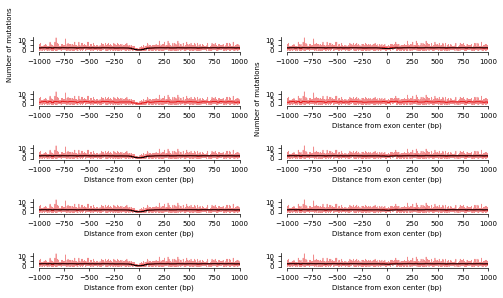

In [77]:
size = 25

listt = ['1mer_DNM_context_golden_synonymous', '1mer_DNM_context_golden_non_synonymous',
        'CpGmer_DNM_context_golden_synonymous', 'CpGmer_DNM_context_golden_non_synonymous',
        '3mer_DNM_context_golden_synonymous', '3mer_DNM_context_golden_non_synonymous',
        '5mer_DNM_context_golden_synonymous', '5mer_DNM_context_golden_non_synonymous',
        '7mer_DNM_context_golden_synonymous', '7mer_DNM_context_golden_non_synonymous']

NROW=5
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
plt.tight_layout()
plt.savefig(path.join('figures', 'internal_exon_centered_DNM_context_binned_selection.svg'), bbox_inches='tight')
plt.show()

## Exons centered analysis, all DNMs

Mutation probabilities were computed genome-wide using DNM. They were used to compute the expected number of mutations based on a generalized k-mer model, with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. for the 3-mer case.

In [78]:
## Get mutations
mutations_file = mutations_folder + 'germinal_ultimate_dataset.bed.gz'
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None)
mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'class']
mutations_df = mutations_df[['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type']]
mutations_df = mutations_df[mutations_df['type'] == 'subs']
mutations_df['ID'] = mutations_df.index + 1

tumor_type = 'germinal'

### 1-mer context dependency, synonymous

In [79]:
k = 1
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category initiator_codon_variant is found 6 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category None is found 10 times.
The category downstream_gene_variant is found 2 times.
The category upstream_gene_variant is found 8 times.
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.


#### Significance through permutations

In [80]:
k = 1
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 50780
Observed at middle exons: 1170
Observed at flanking introns: 46111


In [81]:
k = 1
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,1170,1035.458,46111,46245.542,0.001


In [82]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    12.993477
dtype: float64

In [83]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    12.880646
 dtype: float64, 0    13.106309
 dtype: float64)

### 1-mer context dependency, non_synonymous

In [84]:
k = 1
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category initiator_codon_variant is found 6 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category None is found 10 times.
The category downstream_gene_variant is found 2 times.
The category upstream_gene_variant is found 8 times.
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.


#### Significance through permutations

In [85]:
k = 1
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 50780
Observed at middle exons: 3488
Observed at flanking introns: 46111


In [86]:
k = 1
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,3488,2717.856,46111,46881.144,0.001


In [87]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    28.336453
dtype: float64

In [88]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    28.263691
 dtype: float64, 0    28.409216
 dtype: float64)

### 1-mer context dependency, 9 classes with CpG, synonymous

In [89]:
k = 3
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/CpG_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_excluding_CpG(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_CpGmer_DNM_context_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category initiator_codon_variant is found 6 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category None is found 10 times.
The category downstream_gene_variant is found 2 times.
The category upstream_gene_variant is found 8 times.
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.


#### Significance through permutations

In [90]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/CpG_signatures_DNM_new.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding_CpG(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 50780
Observed at middle exons: 1170
Observed at flanking introns: 46111


In [91]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,1170,1195.464,46111,46085.536,0.786


In [92]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -2.130052
dtype: float64

In [93]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -2.214824
 dtype: float64, 0   -2.045279
 dtype: float64)

### 1-mer context dependency, 9 classes with CpG, non_synonymous

In [94]:
k = 3
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/CpG_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_excluding_CpG(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_CpGmer_DNM_context_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category initiator_codon_variant is found 6 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category None is found 10 times.
The category downstream_gene_variant is found 2 times.
The category upstream_gene_variant is found 8 times.
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.


#### Significance through permutations

In [95]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/CpG_signatures_DNM_new.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding_CpG(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 50780
Observed at middle exons: 3488
Observed at flanking introns: 46111


In [96]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,3488,3175.426,46111,46423.574,0.001


In [97]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    9.84353
dtype: float64

In [98]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    9.784135
 dtype: float64, 0    9.902925
 dtype: float64)

### 3-mer context dependency, synonymous

In [99]:
k = 3
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category initiator_codon_variant is found 6 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category None is found 10 times.
The category downstream_gene_variant is found 2 times.
The category upstream_gene_variant is found 8 times.
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.


#### Significance through permutations

In [100]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 50780
Observed at middle exons: 1170
Observed at flanking introns: 46111


In [101]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,1170,1181.696,46111,46099.304,0.651


In [102]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -0.989764
dtype: float64

In [103]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -1.075904
 dtype: float64, 0   -0.903624
 dtype: float64)

### 3-mer context dependency, non_synonymous

In [104]:
k = 3
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category initiator_codon_variant is found 6 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category None is found 10 times.
The category downstream_gene_variant is found 2 times.
The category upstream_gene_variant is found 8 times.
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.


#### Significance through permutations

In [105]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 50780
Observed at middle exons: 3488
Observed at flanking introns: 46111


In [106]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,3488,3159.642,46111,46439.358,0.001


In [107]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    10.392253
dtype: float64

In [108]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    10.335415
 dtype: float64, 0    10.449092
 dtype: float64)

### 5-mer context dependency, synonymous

In [109]:
k = 5
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category initiator_codon_variant is found 6 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category None is found 10 times.
The category downstream_gene_variant is found 2 times.
The category upstream_gene_variant is found 8 times.
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.


#### Significance through permutations

In [110]:
k = 5
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 50780
Observed at middle exons: 1170
Observed at flanking introns: 46111


In [111]:
k = 5
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,1170,1177.725,46111,46103.275,0.592


In [112]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -0.655926
dtype: float64

In [113]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -0.747989
 dtype: float64, 0   -0.563862
 dtype: float64)

### 5-mer context dependency, non_synonymous

In [114]:
k = 5
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category initiator_codon_variant is found 6 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category None is found 10 times.
The category downstream_gene_variant is found 2 times.
The category upstream_gene_variant is found 8 times.
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.


#### Significance through permutations

In [115]:
k = 5
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_new.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 50780
Observed at middle exons: 3488
Observed at flanking introns: 46111


In [116]:
k = 5
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,3488,3178.357,46111,46420.643,0.001


In [117]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    9.742235
dtype: float64

In [118]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    9.68534
 dtype: float64, 0    9.799129
 dtype: float64)

### 7-mer context dependency, synonymous

In [119]:
k = 7
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category initiator_codon_variant is found 6 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category None is found 10 times.
The category downstream_gene_variant is found 2 times.
The category upstream_gene_variant is found 8 times.
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.


#### Significance through permutations

In [120]:
k = 7
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 50780
Observed at middle exons: 1170
Observed at flanking introns: 46111


In [121]:
k = 7
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,1170,1175.267,46111,46105.733,0.561


In [122]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -0.448153
dtype: float64

In [123]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -0.535776
 dtype: float64, 0   -0.360531
 dtype: float64)

### 7-mer context dependency, non_synonymous

In [124]:
k = 7
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 50780
The total amount of mutations at the exonic sequences are 4757
The category initiator_codon_variant is found 6 times.
The category intron_variant is found 1 times.
The category missense_variant is found 3280 times.
The category None is found 10 times.
The category downstream_gene_variant is found 2 times.
The category upstream_gene_variant is found 8 times.
The category splice_region_variant is found 58 times.
The category splice_donor_variant is found 3 times.
The category 5 is found 2 times.
The category splice_acceptor_variant is found 1 times.
The category stop_gained is found 202 times.
The category synonymous_variant is found 1184 times.


#### Significance through permutations

In [125]:
k = 7
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 50780
Observed at middle exons: 3488
Observed at flanking introns: 46111


In [126]:
k = 7
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,3488,3211.136,46111,46387.864,0.001


In [127]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    8.621995
dtype: float64

In [128]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    8.565944
 dtype: float64, 0    8.678047
 dtype: float64)

### Plot results

Binned average approach. Bin size is 25.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


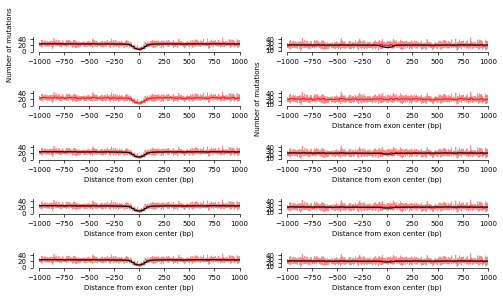

In [129]:
size = 25

listt = ['1mer_DNM_context_synonymous', '1mer_DNM_context_non_synonymous',
        'CpGmer_DNM_context_synonymous', 'CpGmer_DNM_context_non_synonymous',
        '3mer_DNM_context_synonymous', '3mer_DNM_context_non_synonymous',
        '5mer_DNM_context_synonymous', '5mer_DNM_context_non_synonymous',
        '7mer_DNM_context_synonymous', '7mer_DNM_context_non_synonymous']

NROW=5
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
plt.tight_layout()
plt.savefig(path.join('figures', 'internal_exon_centered_DNM_context_binned_selection.svg'), bbox_inches='tight')
plt.show()

## Exons centered analysis, Halldorsson 2019

Mutation probabilities were computed genome-wide using DNM. They were used to compute the expected number of mutations based on a generalized k-mer model, with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. for the 3-mer case.

In [34]:
## Get mutations
mutations_file = mutations_folder + 'germinal_ultimate_dataset.bed.gz'
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None)
mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'class']
mutations_df = mutations_df[['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type']]
mutations_df = mutations_df[mutations_df['type'] == 'subs']
mutations_df = mutations_df[mutations_df['sample'] == 'Halldorsson2019']
mutations_df['ID'] = mutations_df.index + 1

tumor_type = 'germinal'

### 1-mer context dependency, synonymous

In [33]:
k = 1
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_Halldorsson.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_Halldorsson_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 12895
The total amount of mutations at the exonic sequences are 1257
The category splice_acceptor_variant is found 1 times.
The category None is found 3 times.
The category splice_region_variant is found 18 times.
The category synonymous_variant is found 295 times.
The category stop_gained is found 46 times.
The category missense_variant is found 893 times.
The category initiator_codon_variant is found 1 times.


KeyboardInterrupt: 

#### Significance through permutations

In [ ]:
k = 1
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

In [29]:
k = 1
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,115.149,5113,5124.851,0.13


In [30]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    10.291883
dtype: float64

In [31]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    9.966747
 dtype: float64, 0    10.617018
 dtype: float64)

### 1-mer context dependency, non_synonymous

In [32]:
k = 1
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [33]:
k = 1
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [34]:
k = 1
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,299.403,5113,5171.597,0.001


In [35]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    19.57128
dtype: float64

In [36]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    19.362319
 dtype: float64, 0    19.780241
 dtype: float64)

### 1-mer context dependency, 9 classes with CpG, synonymous

In [37]:
k = 3
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/CpG_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_CpG(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_CpGmer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [38]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/CpG_signatures_DNM_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding_CpG(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [39]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,131.129,5113,5108.871,0.679


In [40]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -3.148808
dtype: float64

In [41]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -3.399596
 dtype: float64, 0   -2.898019
 dtype: float64)

### 1-mer context dependency, 9 classes with CpG, non_synonymous

In [42]:
k = 3
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/CpG_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_CpG(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_CpGmer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [43]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/CpG_signatures_DNM_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding_CpG(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [44]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,346.288,5113,5124.712,0.26


In [45]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    3.382156
dtype: float64

In [46]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    3.215567
 dtype: float64, 0    3.548745
 dtype: float64)

### 3-mer context dependency, synonymous

In [47]:
k = 3
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [48]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [49]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,130.631,5113,5109.369,0.644


In [50]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -2.779585
dtype: float64

In [51]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -3.05383
 dtype: float64, 0   -2.50534
 dtype: float64)

### 3-mer context dependency, non_synonymous

In [52]:
k = 3
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [53]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [54]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,343.417,5113,5127.583,0.201


In [55]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    4.246441
dtype: float64

In [56]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    4.080358
 dtype: float64, 0    4.412524
 dtype: float64)

### 5-mer context dependency, synonymous

In [57]:
k = 5
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [58]:
k = 5
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [59]:
k = 5
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,129.603,5113,5110.397,0.595


In [60]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -2.008441
dtype: float64

In [61]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -2.276826
 dtype: float64, 0   -1.740057
 dtype: float64)

### 5-mer context dependency, non_synonymous

In [62]:
k = 5
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [63]:
k = 5
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [64]:
k = 5
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,342.903,5113,5128.097,0.193


In [65]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    4.402703
dtype: float64

In [66]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    4.233248
 dtype: float64, 0    4.572158
 dtype: float64)

### 7-mer context dependency, synonymous

In [67]:
k = 7
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [68]:
k = 7
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [69]:
k = 7
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,126.673,5113,5113.327,0.5


In [70]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    0.258145
dtype: float64

In [71]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -0.018615
 dtype: float64, 0    0.534905
 dtype: float64)

### 7-mer context dependency, non_synonymous

In [72]:
k = 7
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [73]:
k = 7
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [74]:
k = 7
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,345.76,5113,5125.24,0.248


In [75]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    3.540028
dtype: float64

In [76]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    3.370396
 dtype: float64, 0    3.70966
 dtype: float64)

### Plot results

Binned average approach. Bin size is 25.

/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


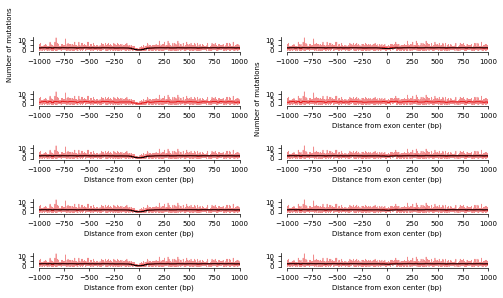

In [77]:
size = 25

listt = ['1mer_DNM_context_golden_synonymous', '1mer_DNM_context_golden_non_synonymous',
        'CpGmer_DNM_context_golden_synonymous', 'CpGmer_DNM_context_golden_non_synonymous',
        '3mer_DNM_context_golden_synonymous', '3mer_DNM_context_golden_non_synonymous',
        '5mer_DNM_context_golden_synonymous', '5mer_DNM_context_golden_non_synonymous',
        '7mer_DNM_context_golden_synonymous', '7mer_DNM_context_golden_non_synonymous']

NROW=5
NCOL=2

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    plot_HD_BINNED(ele, axs[cnt], cnt, size)
    cnt+=1
    
plt.tight_layout()
plt.savefig(path.join('figures', 'internal_exon_centered_DNM_context_binned_selection.svg'), bbox_inches='tight')
plt.show()

## Exons centered analysis, Goldmann 2018

Mutation probabilities were computed genome-wide using DNM. They were used to compute the expected number of mutations based on a generalized k-mer model, with the method described in the **Exon-centered and intron-centered mutational analyses** section at Frigola et al. for the 3-mer case.

In [26]:
## Get mutations
mutations_file = mutations_folder + 'germinal_ultimate_dataset.bed.gz'
mutations_df = pd.read_csv(mutations_file, sep="\t", header=None)
mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type', 'class']
mutations_df = mutations_df[['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type']]
mutations_df = mutations_df[mutations_df['type'] == 'subs']
mutations_df = mutations_df[mutations_df['sample'] == 'Goldmann2018']
mutations_df['ID'] = mutations_df.index + 1

tumor_type = 'germinal'

### 1-mer context dependency, synonymous

In [27]:
k = 1
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [28]:
k = 1
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [29]:
k = 1
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,115.149,5113,5124.851,0.13


In [30]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    10.291883
dtype: float64

In [31]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    9.966747
 dtype: float64, 0    10.617018
 dtype: float64)

### 1-mer context dependency, non_synonymous

In [32]:
k = 1
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [33]:
k = 1
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [34]:
k = 1
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,299.403,5113,5171.597,0.001


In [35]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    19.57128
dtype: float64

In [36]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    19.362319
 dtype: float64, 0    19.780241
 dtype: float64)

### 1-mer context dependency, 9 classes with CpG, synonymous

In [37]:
k = 3
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/CpG_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_CpG(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_CpGmer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [38]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/CpG_signatures_DNM_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding_CpG(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [39]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,131.129,5113,5108.871,0.679


In [40]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -3.148808
dtype: float64

In [41]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -3.399596
 dtype: float64, 0   -2.898019
 dtype: float64)

### 1-mer context dependency, 9 classes with CpG, non_synonymous

In [42]:
k = 3
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/CpG_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_CpG(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_CpGmer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [43]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/CpG_signatures_DNM_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding_CpG(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [44]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_CpGmer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,346.288,5113,5124.712,0.26


In [45]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    3.382156
dtype: float64

In [46]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    3.215567
 dtype: float64, 0    3.548745
 dtype: float64)

### 3-mer context dependency, synonymous

In [47]:
k = 3
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [48]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [49]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,130.631,5113,5109.369,0.644


In [50]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -2.779585
dtype: float64

In [51]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -3.05383
 dtype: float64, 0   -2.50534
 dtype: float64)

### 3-mer context dependency, non_synonymous

In [52]:
k = 3
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [53]:
k = 3
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_signatures_DNM_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [54]:
k = 3
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,343.417,5113,5127.583,0.201


In [55]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    4.246441
dtype: float64

In [56]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    4.080358
 dtype: float64, 0    4.412524
 dtype: float64)

### 5-mer context dependency, synonymous

In [57]:
k = 5
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [58]:
k = 5
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [59]:
k = 5
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,129.603,5113,5110.397,0.595


In [60]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0   -2.008441
dtype: float64

In [61]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -2.276826
 dtype: float64, 0   -1.740057
 dtype: float64)

### 5-mer context dependency, non_synonymous

In [62]:
k = 5
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [63]:
k = 5
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [64]:
k = 5
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,342.903,5113,5128.097,0.193


In [65]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    4.402703
dtype: float64

In [66]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    4.233248
 dtype: float64, 0    4.572158
 dtype: float64)

### 7-mer context dependency, synonymous

In [67]:
k = 7
middle_distance_threshold = 1000
include = 'synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [68]:
k = 7
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 127
Observed at flanking introns: 5113


In [69]:
k = 7
results = []
RANDOMIZATION = 1000
include = 'synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,127,126.673,5113,5113.327,0.5


In [70]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    0.258145
dtype: float64

In [71]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0   -0.018615
 dtype: float64, 0    0.534905
 dtype: float64)

### 7-mer context dependency, non_synonymous

In [72]:
k = 7
middle_distance_threshold = 1000
include = 'non_synonymous'
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'

exons_centered_results = obs_exp_muts_excluding_kmer(mutations_df, exons_coords_df, signatures_file, tumor_type, 
                            middle_distance_threshold, k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results.to_csv('results/exons_centered_' + str(k) + 'mer_DNM_context_golden_' + str(include) + '.tsv', sep="\t", header=True, index=False)

The total amount of mutations at the middle exon-centered sequences is 5598
The total amount of mutations at the exonic sequences are 494
The category initiator_codon_variant is found 1 times.
The category missense_variant is found 336 times.
The category splice_region_variant is found 2 times.
The category stop_gained is found 25 times.
The category synonymous_variant is found 130 times.


#### Significance through permutations

In [73]:
k = 7
middle_distance_threshold = 1000
signatures_file = 'results/' + str(k) + 'mer_DNM_signatures_decomp_golden.txt'
include = 'non_synonymous'

(exons_centered_results, exonic_obs, intronic_obs) = stacked_sequence_level_permutation_excluding(mutations_df,
                                    exons_coords_df, signatures_file, tumor_type, middle_distance_threshold,
                                    k, include, tb_consequence_type, consequence_rank_dict)

exons_centered_results = pd.DataFrame.transpose(exons_centered_results)
exons_centered_results.to_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'),
                              sep="\t", header=True, index=False)

Total amount of mutations at the middle exon-centered sequences is 5598
Observed at middle exons: 358
Observed at flanking introns: 5113


In [74]:
k = 7
results = []
RANDOMIZATION = 1000
include = 'non_synonymous'
    
# Read the expected exon and intron mutation counts from permutations
rand_output = pd.read_csv(path.join('results', 'exons_centered_' + str(k) + 'mer_permut_' + include + '_golden.tsv'), sep="\t")
    
# count the number of times the expected exon mutations is higher than the observed
count = len(rand_output[rand_output['exon_Exp'] >= exonic_obs])
    
if count == 0:
    count = 1 
    
results.append([exonic_obs, rand_output['exon_Exp'].mean(), intronic_obs, rand_output['intron_Exp'].mean(), count/RANDOMIZATION])
    
results_df = pd.DataFrame(results)
results_df.columns = ['obs_exon_cnt', 'exp_exon_cnt','obs_intron_cnt', 'exp_intron_cnt', 'empirical_pvalue']
results_df

,obs_exon_cnt,exp_exon_cnt,obs_intron_cnt,exp_intron_cnt,empirical_pvalue
0,358,345.76,5113,5125.24,0.248


In [75]:
exonic_increase = (results_df["obs_exon_cnt"]/results_df["exp_exon_cnt"]-1)*100
exonic_increase

0    3.540028
dtype: float64

In [76]:
rand_output['increase'] = (exonic_obs/rand_output['exon_Exp']-1)*100
error = (st.stdev(rand_output['increase'].tolist())/np.sqrt(1000))
(exonic_increase-error, exonic_increase+error)

(0    3.370396
 dtype: float64, 0    3.70966
 dtype: float64)